In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, make_scorer, mean_squared_error #MAE
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from google.colab import drive
if not os.path.isdir('/content/drive'):
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
INPUT_PATH = "/content/drive/MyDrive/GCI/titanic/Input"

train = pd.read_csv(os.path.join(INPUT_PATH, "train.csv"))
test = pd.read_csv(os.path.join(INPUT_PATH, "test.csv"))
train["Perished"] = train["Perished"].replace({1:0, 0:1})

data = pd.concat([train, test], ignore_index = True)

# 特徴量作成

In [ ]:
data["Ticket_Freq"] = data["Ticket"].str.len()
data["Title"] =  data["Name"].apply(lambda x:x.split(',')[1].split('.')[0].strip())
data['Surname'] = data['Name'].apply(lambda x: x.split(',')[0])
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['isAlone'] = 0
data.loc[data.FamilySize != 1, 'isAlone'] = 1

# Bins
data['FareBin'] = pd.qcut(data['Fare'], 5)
label = LabelEncoder()
data['FareBin_Code'] = label.fit_transform(data['FareBin'])

data['AgeBin'] = pd.qcut(data['Age'], 4)
label = LabelEncoder()
data['AgeBin_Code'] = label.fit_transform(data['AgeBin'])

# 補完
data["Fare"] = data["Fare"].fillna(data["Fare"].mean())
data['Embarked'] = data['Embarked'].fillna('S')

In [ ]:
# 辞書型でmap一括処理
Honorifics_Dict = {}
Honorifics_Dict.update(dict.fromkeys(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer'))
Honorifics_Dict.update(dict.fromkeys(['Don', 'Sir', 'the Countess', 'Dona', 'Lady'], 'Royalty'))
Honorifics_Dict.update(dict.fromkeys(['Mme', 'Ms', 'Mrs'], 'Mrs'))
Honorifics_Dict.update(dict.fromkeys(['Mlle', 'Miss'], 'Miss'))
Honorifics_Dict.update(dict.fromkeys(['Mr'], 'Mr'))
Honorifics_Dict.update(dict.fromkeys(['Master','Jonkheer'], 'Master'))

data['Honorifics'] = data['Title'].map(Honorifics_Dict)

In [ ]:
data["FamilyOneSurvived"] = 0
data["FamilyAllDied"] = 0

data_train = data.iloc[:len(train)]
data_test = data.iloc[len(train):]

for i in range(0, len(data_train)):
  name = data_train["Surname"].iloc[i]

  tmp_df = data_train[(data_train["Surname"]==name) & (data_train["PassengerId"] != i+1)]["Perished"]
  tmp_cnt = np.mean(list(tmp_df))

  if tmp_cnt > 0:
    data_train["FamilyOneSurvived"].iloc[i] = 1
  elif tmp_cnt == 0:
    data_train["FamilyAllDied"].iloc[i] = 1

for i in range(len(data_test)):
  name = data_test["Surname"].iloc[i]
  tmp_df = data_train[data_train["Surname"] == name]["Perished"]
  tmp_cnt = np.mean(list(tmp_df))

  if tmp_cnt > 0:
    data_test["FamilyOneSurvived"].iloc[i] = 1
  elif tmp_cnt == 0:
    data_test["FamilyAllDied"].iloc[i] = 1

data = pd.concat([data_train, data_test], axis=0)

# Age予測

In [ ]:
age = data[['Age', 'Sex', 'Honorifics', 'Fare', 'FamilyOneSurvived', 'FamilyAllDied', 'Ticket_Freq']]

# pclass -> dummy
age_dummies = pd.get_dummies(age)
pclass_dummies = pd.get_dummies(data['Pclass'], prefix="Pclass")
age_dummies = pd.concat([pclass_dummies, age_dummies], axis=1)

known_age = age_dummies[age_dummies.Age.notnull()]
null_age = age_dummies[age_dummies.Age.isnull()]

X = known_age.drop('Age', axis=1)
y = known_age['Age']

model = RandomForestRegressor(max_depth=3, random_state=42)
model.fit(X, y)

pred = model.predict(null_age.drop('Age', axis=1))
data.loc[(data.Age.isnull()),'Age'] = pred

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error #MSE

In [ ]:
# parmas tuning
# def rmse(y_true,y_pred):
#     rmse = np.sqrt(mean_squared_error(y_true,y_pred))
#     print('rmse',rmse)
#     return rmse

# model = clf.best_estimator_
# params= {'eta': 0.1, 'gamma': 0.01, 'max_depth': 4, 'min_child_weigh': 1, 'n_estimators': 40, 'nthread': 2}
# model = xgb.XGBRegressor(**params)

{'eta': 0.1,
 'gamma': 0.01,
 'max_depth': 4,
 'min_child_weigh': 1,
 'n_estimators': 40,
 'nthread': 2}

In [ ]:
pclass_dummy = pd.get_dummies(data["Pclass"], prefix="Pclass")
Honorifics_dummy = pd.get_dummies(data["Honorifics"])
Embarked_dummy = pd.get_dummies(data["Embarked"])

data = pd.concat([data, pclass_dummy, Honorifics_dummy, Embarked_dummy], axis=1)
data.head(1)

PassengerId  Perished  Pclass                     Name  Sex   Age  SibSp  \
0            1       0.0       3  Braund, Mr. Owen Harris    0  22.0      1   

   Parch     Ticket  Fare  ... Pclass_3 Master  Miss Mr Mrs  Officer  Royalty  \
0      0  A/5 21171  7.25  ...        1      0     0  1   0        0        0   

   C  Q  S  
0  0  0  1  

[1 rows x 36 columns]

In [ ]:
data["Age_adj"] = data["Age"]/80
data["FamilySize_adj"] = (data["SibSp"] + data["Parch"] + 1) /11
data["Fare_Adj"] = data["Fare"]/data["Ticket_Freq"]/222
data["Ticket_Freq_adj"] = data["Ticket_Freq"]/data["Ticket_Freq"].max()
data["boy"] = 0
data.loc[((data["Honorifics"] == "Master") & (data["Sex"] == 0)), "boy"] = 1
data["Pclass_adj"] = data["Pclass"] / 3.0

# XGB

In [ ]:
train_df = data.iloc[:len(train)][['Perished', "FamilyAllDied", 'Fare_Adj',
                                   'Pclass_adj', 'Mr', 'Officer', 'FamilySize_adj']]

test_df = data.iloc[len(train):][['Perished', "FamilyAllDied", 'Fare_Adj',
                                  'Pclass_adj', 'Mr', 'Officer', 'FamilySize_adj']]

X = train_df.drop('Perished', 1)
y = train_df['Perished']
X_test = test_df.drop('Perished', 1)

model = xgb.XGBClassifier(max_depth=3, 
                          learning_rate=0.01, 
                          n_estimators=100, 
                          random_state=42
                          )

model.fit(X, y, eval_metric='auc')
pred_xgb_class = model.predict(X_test)
pred_xgb_proba = model.predict_proba(X_test)[:, 1]

# 過学習確認
print("model score",model.score(X, y))

model score 0.8529741863075196


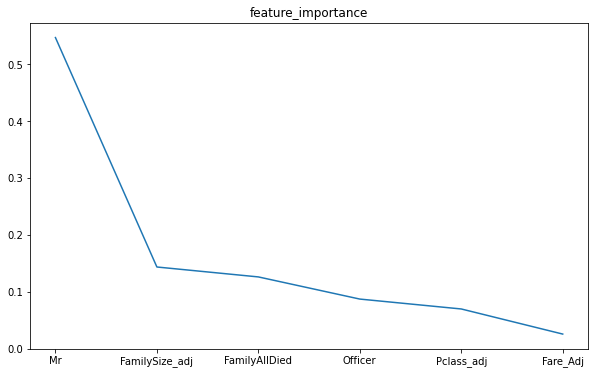

In [ ]:
feature = pd.DataFrame()
feature["columns"] = X.columns
feature["score"] = model.feature_importances_
feature = feature.sort_values(by='score', ascending=False)

plt.figure(figsize=(10,6))
plt.plot(feature["columns"], feature["score"])
plt.title("feature_importance")
plt.show()

# 提出

In [ ]:
# for ensemble
submissions = pd.read_csv("/content/drive/MyDrive/GCI/titanic/Input/gender_submission.csv")
submissions["Perished"] = pred_xgb_class.astype('int64')
submissions.to_csv("/content/drive/MyDrive/GCI/titanic/Output/ensemble/XGB-0.8158.csv", index=False)

# for kaggle
submissions = submissions.rename(columns={"Perished":"Survived"})
submissions.to_csv("/content/drive/MyDrive/GCI/titanic/Output/kaggle/XGB-0.8158.csv", index=False)
# Kaggle -> 0.8158

# for GCI
submissions = submissions.rename(columns={"Survived":"Perished"})
submissions["Perished"] = submissions["Perished"].replace({1:0, 0:1})
submissions.to_csv("/content/drive/MyDrive/GCI/titanic/Output/gci/GCI-XGB-0.8158.csv", index=False)

# 参考・引用
*  https://www.kaggle.com/code/cdeotte/titanic-deep-net-0-82296
*  https://qiita.com/shiroino11111/items/21bf1303587eeae0fc30
*  https://qiita.com/jun40vn/items/d8a1f71fae680589e05c